In [15]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import sys
import os

from architecture.seq2seq import LSTMSeq2Seq, AttentionLSTMSeq2Seq, TransformerSeq2Seq


In [16]:

SEQ_LEN = 30
OUTPUT_LEN = 1
BATCH_SIZE = 32
HIDDEN_SIZE = 64
NUM_LAYERS = 1
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

FEATURE_COLS = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]

print(f"Using device: {DEVICE}")


Using device: cuda


In [17]:

xom_df = pd.read_csv("/oak/stanford/groups/rondror/users/nishankr/229proj/data/XOM_data.csv")
print(f"XOM data shape: {xom_df.shape}")
print(f"Columns: {xom_df.columns.tolist()}")
print(xom_df.head())


XOM data shape: (977, 7)
Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
         Date       Open       High        Low      Close  Adj Close    Volume
0  2021-01-04  41.450001  42.250000  41.000000  41.500000  35.163219  27764700
1  2021-01-05  41.840000  44.799999  41.830002  43.500000  36.857830  44035100
2  2021-01-06  44.410000  45.099998  43.700001  44.610001  37.798344  36484800
3  2021-01-07  45.000000  45.570000  44.529999  44.959999  38.094898  29528100
4  2021-01-08  45.200001  45.820000  44.950001  45.459999  38.518559  28628200


In [18]:

xom_values = xom_df[FEATURE_COLS].values.astype(np.float32)
T_xom, D = xom_values.shape
print(f"XOM timesteps: {T_xom}, Features: {D}")


XOM timesteps: 977, Features: 6


In [19]:

scaler = StandardScaler()
scaler.fit(xom_values)
xom_values_scaled = scaler.transform(xom_values).astype(np.float32)

print(f"Scaled XOM data shape: {xom_values_scaled.shape}")
print(f"Scaled XOM stats - Mean: {xom_values_scaled.mean(axis=0)}, Std: {xom_values_scaled.std(axis=0)}")
print("NOTE: Using XOM's own scaler - model should adapt to normalized patterns")


Scaled XOM data shape: (977, 6)
Scaled XOM stats - Mean: [ 3.1236006e-08  3.1236006e-08  0.0000000e+00  3.1236006e-08
  0.0000000e+00 -1.5618003e-08], Std: [0.99999994 0.99999994 1.         0.99999994 1.         1.        ]
NOTE: Using XOM's own scaler - model should adapt to normalized patterns


In [20]:

X_xom_list, y_xom_list, idx_xom_list = [], [], []
for t in range(SEQ_LEN, T_xom - OUTPUT_LEN + 1):
    X_xom_list.append(xom_values_scaled[t - SEQ_LEN : t])
    y_xom_list.append(xom_values_scaled[t : t + OUTPUT_LEN].reshape(-1, D))
    idx_xom_list.append(t)

X_xom = np.stack(X_xom_list, axis=0)
y_xom = np.stack(y_xom_list, axis=0)
indices_xom = np.array(idx_xom_list)


y_xom = y_xom[:, 0, :]

print(f"XOM sequences: {X_xom.shape[0]}")
print(f"XOM input shape: {X_xom.shape}, target shape: {y_xom.shape}")


XOM sequences: 947
XOM input shape: (947, 30, 6), target shape: (947, 6)


In [21]:

xom_dataset = TensorDataset(
    torch.from_numpy(X_xom).float(),
    torch.from_numpy(y_xom).float()
)
xom_loader = DataLoader(xom_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"XOM DataLoader created with {len(xom_dataset)} samples")


XOM DataLoader created with 947 samples


In [22]:

def scaled_rmse(y_true_scaled, y_pred_scaled):
    mse = np.mean((y_true_scaled - y_pred_scaled) ** 2, axis=0)
    rmse = np.sqrt(mse)
    return rmse, float(rmse.mean())

def mape(y_true, y_pred, eps=1e-8):
    denom = np.maximum(np.abs(y_true), eps)
    ape = np.abs((y_pred - y_true) / denom)
    per_feature = ape.mean(axis=0) * 100.0
    overall = float(per_feature.mean())
    return per_feature, overall

def mean_directional_accuracy(y_true, y_pred, full_series, target_indices):
    prev_idx = target_indices - 1
    prev_vals = full_series[prev_idx]
    actual_change = np.sign(y_true - prev_vals)
    pred_change = np.sign(y_pred - prev_vals)
    mask = actual_change != 0
    matches = (actual_change == pred_change) & mask
    per_feature = np.zeros(y_true.shape[1])
    for d in range(y_true.shape[1]):
        if mask[:, d].sum() == 0:
            per_feature[d] = np.nan
        else:
            per_feature[d] = matches[:, d].sum() / mask[:, d].sum()
    overall = matches.sum() / np.maximum(mask.sum(), 1)
    return per_feature, float(overall)

def r2_score_multi(y_true, y_pred):
    ss_res = np.sum((y_true - y_pred) ** 2, axis=0)
    ss_tot = np.sum((y_true - y_true.mean(axis=0)) ** 2, axis=0)
    per_feature = 1.0 - ss_res / ss_tot
    overall = 1.0 - ss_res.sum() / ss_tot.sum()
    return per_feature, float(overall)

def forecast_bias(y_true, y_pred, tol_frac=0.01):
    errors = y_pred - y_true
    mean_err = errors.mean(axis=0)
    mean_abs = np.mean(np.abs(y_true), axis=0) + 1e-8
    labels = []
    for m, ma in zip(mean_err, mean_abs):
        tol = tol_frac * ma
        if m > tol:
            labels.append("Positive bias (over-forecast)")
        elif m < -tol:
            labels.append("Negative bias (under-forecast)")
        else:
            labels.append("Near-unbiased")
    return mean_err, labels

def make_results_row(model_name, y_true_scaled, y_pred_scaled,
                     y_true_orig, y_pred_orig,
                     full_orig_series, test_indices):
    """Create a results row for spreadsheet"""

    mse = np.mean((y_true_scaled - y_pred_scaled) ** 2, axis=0)
    rmse_series = np.sqrt(mse)
    scaled_rmse = float(rmse_series.mean())

    eps = 1e-8
    ape = np.abs((y_pred_orig - y_true_orig) / np.maximum(np.abs(y_true_orig), eps))
    mape_per_feat = np.mean(ape, axis=0) * 100.0
    mape = float(np.mean(mape_per_feat))

    ss_res = np.sum((y_true_orig - y_pred_orig) ** 2)
    ss_tot = np.sum((y_true_orig - y_true_orig.mean(axis=0)) ** 2)
    r2 = 1.0 - ss_res / (ss_tot + eps)

    mean_err = np.mean(y_pred_orig - y_true_orig)
    bias_label = "Over-forecast (too high)" if mean_err > 0 else "Under-forecast (too low)" if mean_err < 0 else "Unbiased"

    prev_idx = test_indices - 1
    prev_vals = full_orig_series[prev_idx]
    actual_change = np.sign(y_true_orig - prev_vals)
    pred_change = np.sign(y_pred_orig - prev_vals)
    mask = actual_change != 0
    matches = (actual_change == pred_change) & mask
    mda = matches.sum() / max(mask.sum(), 1)

    return {
        "Model": model_name,
        "Scaled RMSE": scaled_rmse,
        "MAPE": mape,
        "Mean Directional Accuracy (MDA)": float(mda),
        "R^2": r2,
        "Forecast Bias?": bias_label
    }


In [23]:

model_lstm = LSTMSeq2Seq(
    input_size=D,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=D,
    bidirectional=False,
    dropout=0.1
).to(DEVICE)


model_lstm.load_state_dict(torch.load('LSTMSeq2SeqTrained.pt', map_location=DEVICE))
model_lstm.eval()

print("LSTM Seq2Seq model loaded and ready for inference!")


LSTM Seq2Seq model loaded and ready for inference!


In [24]:

model_lstm.eval()
all_preds_lstm = []
all_true_lstm = []

with torch.no_grad():
    for xb, yb in xom_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model_lstm(xb, OUTPUT_LEN)
        preds = preds[:, 0, :]
        
        all_preds_lstm.append(preds.cpu().numpy())
        all_true_lstm.append(yb.cpu().numpy())

preds_lstm_scaled = np.concatenate(all_preds_lstm, axis=0)
true_lstm_scaled = np.concatenate(all_true_lstm, axis=0)

preds_lstm_orig = scaler.inverse_transform(preds_lstm_scaled)
true_lstm_orig = scaler.inverse_transform(true_lstm_scaled)

print(f"Predictions shape: {preds_lstm_orig.shape}")


Predictions shape: (947, 6)


In [25]:

rmse_pf_lstm, rmse_overall_lstm = scaled_rmse(true_lstm_scaled, preds_lstm_scaled)
mape_pf_lstm, mape_overall_lstm = mape(true_lstm_orig, preds_lstm_orig)
mda_pf_lstm, mda_overall_lstm = mean_directional_accuracy(
    true_lstm_orig, preds_lstm_orig, xom_values, indices_xom
)
r2_pf_lstm, r2_overall_lstm = r2_score_multi(true_lstm_orig, preds_lstm_orig)
mean_err_pf_lstm, bias_labels_lstm = forecast_bias(true_lstm_orig, preds_lstm_orig)

print("\n=== XOM METRICS (LSTM Seq2Seq) ===")
for i, name in enumerate(FEATURE_COLS):
    print(f"\nFeature: {name}")
    print(f"  Scaled RMSE: {rmse_pf_lstm[i]:.4f}")
    print(f"  MAPE:        {mape_pf_lstm[i]:.2f}%")
    print(f"  MDA:         {mda_pf_lstm[i]:.3f}")
    print(f"  R^2:         {r2_pf_lstm[i]:.3f}")
    print(f"  Mean error:  {mean_err_pf_lstm[i]:.4f}  -> {bias_labels_lstm[i]}")

print("\nOverall (all features combined):")
print(f"  Scaled RMSE (mean): {rmse_overall_lstm:.4f}")
print(f"  MAPE (mean):        {mape_overall_lstm:.2f}%")
print(f"  MDA (overall):      {mda_overall_lstm:.3f}")
print(f"  R^2 (overall):      {r2_overall_lstm:.3f}")



=== XOM METRICS (LSTM Seq2Seq) ===

Feature: Open
  Scaled RMSE: 0.0677
  MAPE:        1.37%
  MDA:         0.646
  R^2:         0.995
  Mean error:  0.2258  -> Near-unbiased

Feature: High
  Scaled RMSE: 0.0773
  MAPE:        1.52%
  MDA:         0.550
  R^2:         0.993
  Mean error:  0.2378  -> Near-unbiased

Feature: Low
  Scaled RMSE: 0.0767
  MAPE:        1.52%
  MDA:         0.541
  R^2:         0.994
  Mean error:  0.2312  -> Near-unbiased

Feature: Close
  Scaled RMSE: 0.0879
  MAPE:        1.74%
  MDA:         0.508
  R^2:         0.991
  Mean error:  0.2256  -> Near-unbiased

Feature: Adj Close
  Scaled RMSE: 0.0890
  MAPE:        1.94%
  MDA:         0.499
  R^2:         0.991
  Mean error:  0.3018  -> Near-unbiased

Feature: Volume
  Scaled RMSE: 0.9346
  MAPE:        30.28%
  MDA:         0.625
  R^2:         0.108
  Mean error:  172496.1875  -> Near-unbiased

Overall (all features combined):
  Scaled RMSE (mean): 0.2222
  MAPE (mean):        6.39%
  MDA (overall):    

In [26]:

row_lstm = make_results_row(
    "LSTM_Seq2Seq_XOM",
    true_lstm_scaled, preds_lstm_scaled,
    true_lstm_orig, preds_lstm_orig,
    xom_values, indices_xom
)
print("\nRow for spreadsheet:")
print(row_lstm)



Row for spreadsheet:
{'Model': 'LSTM_Seq2Seq_XOM', 'Scaled RMSE': 0.22221429646015167, 'MAPE': 6.394689559936523, 'Mean Directional Accuracy (MDA)': 0.5616510848474158, 'R^2': np.float32(0.10811454), 'Forecast Bias?': 'Over-forecast (too high)'}


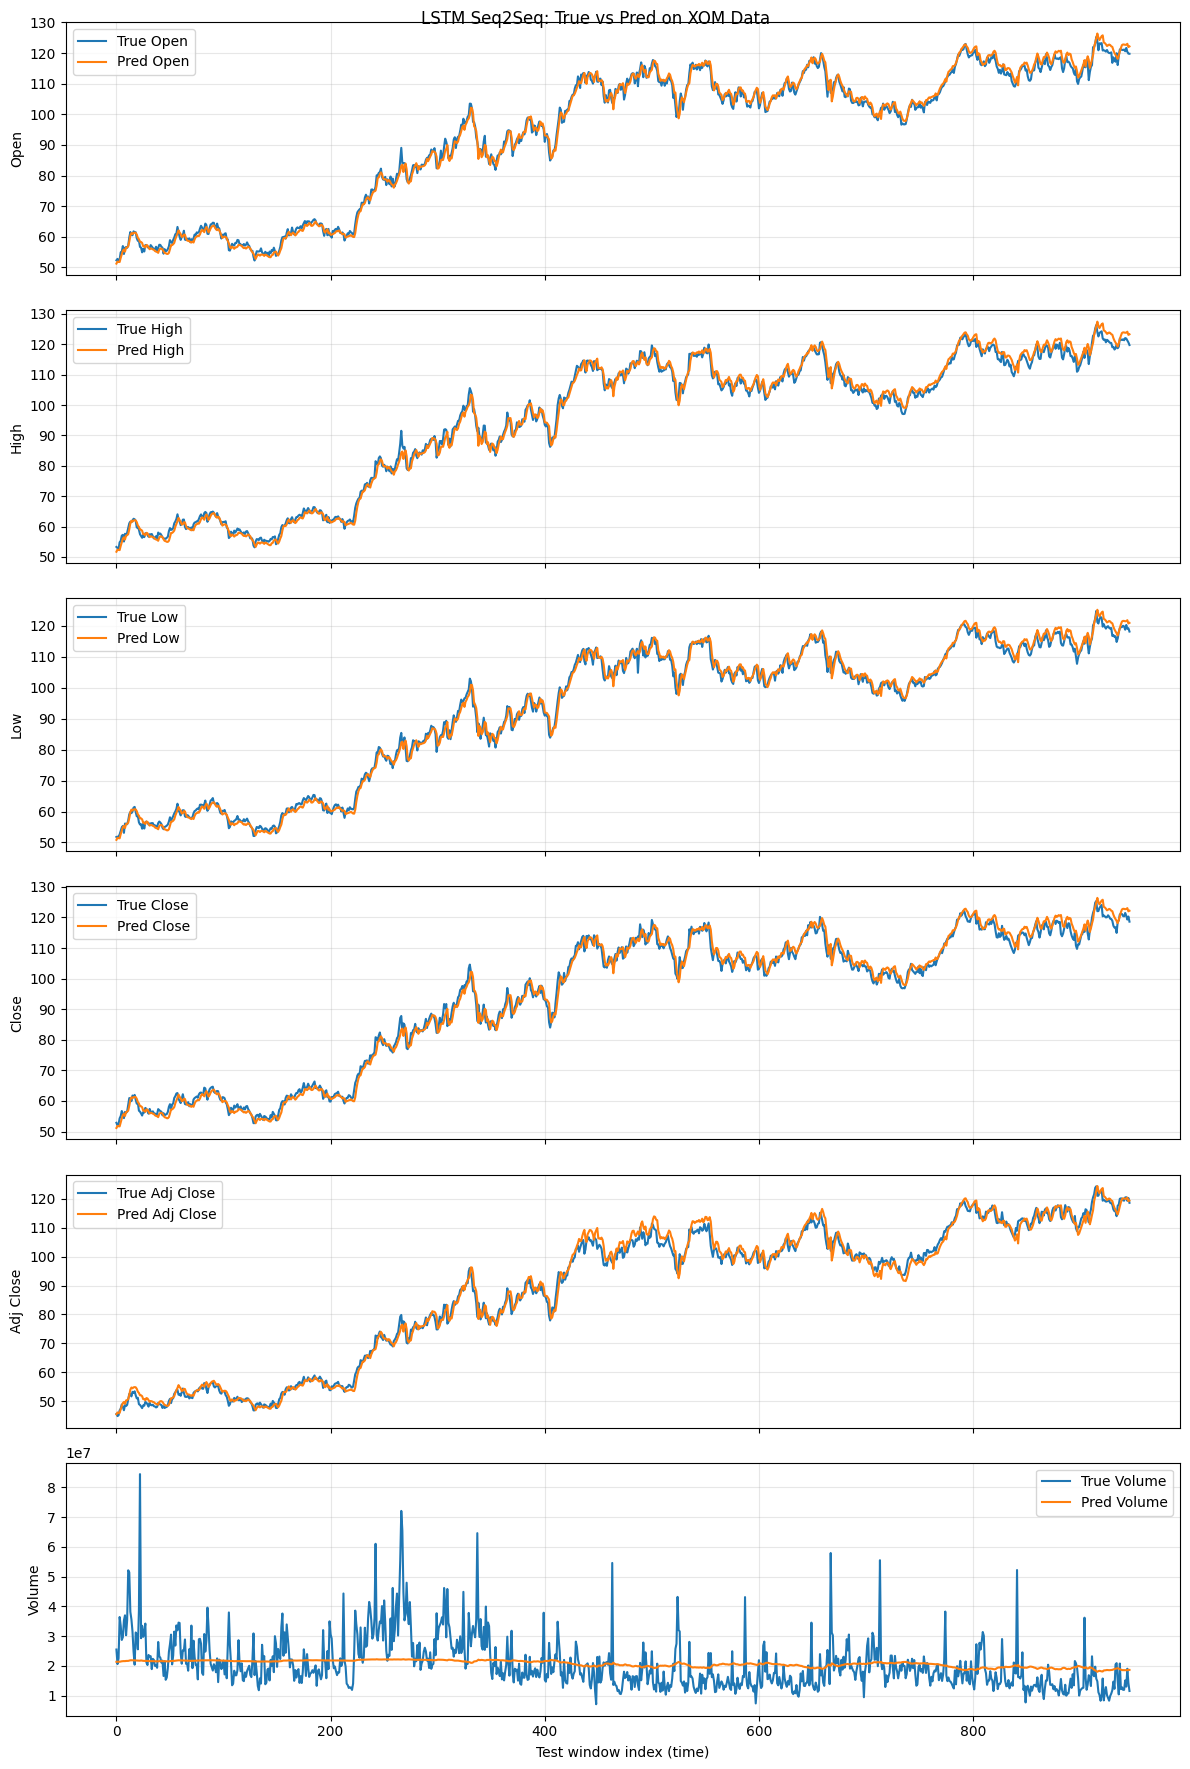

In [27]:

n_features = true_lstm_orig.shape[1]
x = np.arange(true_lstm_orig.shape[0])
fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features), sharex=True)
if n_features == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    ax.plot(x, true_lstm_orig[:, i], label=f"True {FEATURE_COLS[i]}")
    ax.plot(x, preds_lstm_orig[:, i], label=f"Pred {FEATURE_COLS[i]}")
    ax.set_ylabel(FEATURE_COLS[i])
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
axes[-1].set_xlabel("Test window index (time)")
plt.suptitle("LSTM Seq2Seq: True vs Pred on XOM Data")
fig.tight_layout()
plt.show()


## Test Attention LSTM Seq2Seq Model


In [28]:

model_attn = AttentionLSTMSeq2Seq(
    input_size=D,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    output_size=D,
    bidirectional=False,
    dropout=0.1
).to(DEVICE)


model_attn.load_state_dict(torch.load('AttnLSTMSeq2SeqTrained.pt', map_location=DEVICE))
model_attn.eval()

print("Attention LSTM Seq2Seq model loaded and ready for inference!")


Attention LSTM Seq2Seq model loaded and ready for inference!


In [29]:

model_attn.eval()
all_preds_attn = []
all_true_attn = []

with torch.no_grad():
    for xb, yb in xom_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model_attn(xb, OUTPUT_LEN)
        preds = preds[:, 0, :]
        
        all_preds_attn.append(preds.cpu().numpy())
        all_true_attn.append(yb.cpu().numpy())

preds_attn_scaled = np.concatenate(all_preds_attn, axis=0)
true_attn_scaled = np.concatenate(all_true_attn, axis=0)


preds_attn_orig = scaler.inverse_transform(preds_attn_scaled)
true_attn_orig = scaler.inverse_transform(true_attn_scaled)

print(f"Predictions shape: {preds_attn_orig.shape}")


Predictions shape: (947, 6)


In [30]:

rmse_pf_attn, rmse_overall_attn = scaled_rmse(true_attn_scaled, preds_attn_scaled)
mape_pf_attn, mape_overall_attn = mape(true_attn_orig, preds_attn_orig)
mda_pf_attn, mda_overall_attn = mean_directional_accuracy(
    true_attn_orig, preds_attn_orig, xom_values, indices_xom
)
r2_pf_attn, r2_overall_attn = r2_score_multi(true_attn_orig, preds_attn_orig)
mean_err_pf_attn, bias_labels_attn = forecast_bias(true_attn_orig, preds_attn_orig)

print("\n=== XOM METRICS (Attention LSTM Seq2Seq) ===")
for i, name in enumerate(FEATURE_COLS):
    print(f"\nFeature: {name}")
    print(f"  Scaled RMSE: {rmse_pf_attn[i]:.4f}")
    print(f"  MAPE:        {mape_pf_attn[i]:.2f}%")
    print(f"  MDA:         {mda_pf_attn[i]:.3f}")
    print(f"  R^2:         {r2_pf_attn[i]:.3f}")
    print(f"  Mean error:  {mean_err_pf_attn[i]:.4f}  -> {bias_labels_attn[i]}")

print("\nOverall (all features combined):")
print(f"  Scaled RMSE (mean): {rmse_overall_attn:.4f}")
print(f"  MAPE (mean):        {mape_overall_attn:.2f}%")
print(f"  MDA (overall):      {mda_overall_attn:.3f}")
print(f"  R^2 (overall):      {r2_overall_attn:.3f}")



=== XOM METRICS (Attention LSTM Seq2Seq) ===

Feature: Open
  Scaled RMSE: 0.0783
  MAPE:        1.71%
  MDA:         0.627
  R^2:         0.993
  Mean error:  0.1285  -> Near-unbiased

Feature: High
  Scaled RMSE: 0.0867
  MAPE:        1.86%
  MDA:         0.543
  R^2:         0.992
  Mean error:  0.1227  -> Near-unbiased

Feature: Low
  Scaled RMSE: 0.0895
  MAPE:        1.93%
  MDA:         0.545
  R^2:         0.991
  Mean error:  0.1371  -> Near-unbiased

Feature: Close
  Scaled RMSE: 0.0994
  MAPE:        2.11%
  MDA:         0.486
  R^2:         0.989
  Mean error:  0.2037  -> Near-unbiased

Feature: Adj Close
  Scaled RMSE: 0.0954
  MAPE:        2.11%
  MDA:         0.488
  R^2:         0.990
  Mean error:  0.3538  -> Near-unbiased

Feature: Volume
  Scaled RMSE: 0.7567
  MAPE:        20.36%
  MDA:         0.646
  R^2:         0.415
  Mean error:  -572972.7500  -> Negative bias (under-forecast)

Overall (all features combined):
  Scaled RMSE (mean): 0.2010
  MAPE (mean):      

In [31]:

row_attn = make_results_row(
    "Attention_LSTM_Seq2Seq_XOM",
    true_attn_scaled, preds_attn_scaled,
    true_attn_orig, preds_attn_orig,
    xom_values, indices_xom
)
print("\nRow for spreadsheet:")
print(row_attn)



Row for spreadsheet:
{'Model': 'Attention_LSTM_Seq2Seq_XOM', 'Scaled RMSE': 0.20101241767406464, 'MAPE': 5.014004230499268, 'Mean Directional Accuracy (MDA)': 0.5558299523725525, 'R^2': np.float32(0.41529244), 'Forecast Bias?': 'Under-forecast (too low)'}


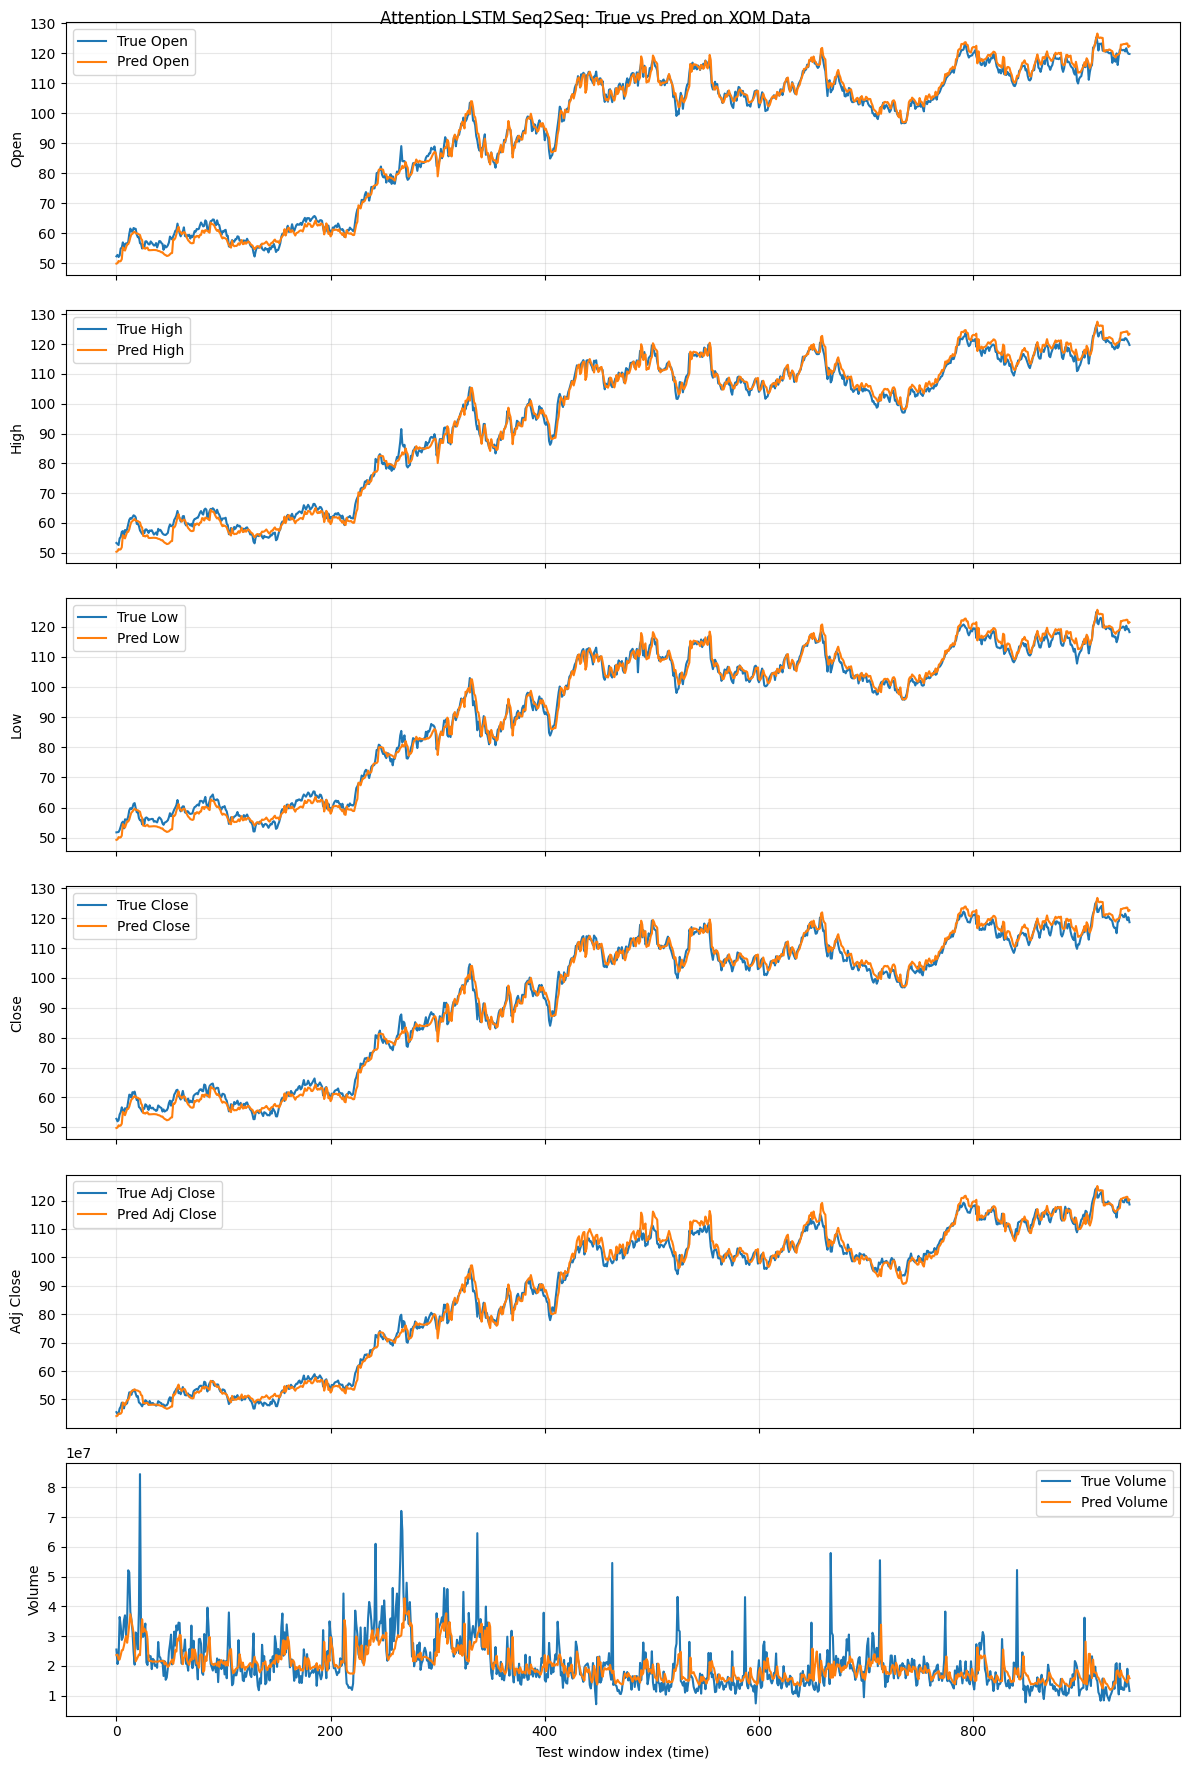

In [32]:

n_features = true_attn_orig.shape[1]
x = np.arange(true_attn_orig.shape[0])
fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features), sharex=True)
if n_features == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    ax.plot(x, true_attn_orig[:, i], label=f"True {FEATURE_COLS[i]}")
    ax.plot(x, preds_attn_orig[:, i], label=f"Pred {FEATURE_COLS[i]}")
    ax.set_ylabel(FEATURE_COLS[i])
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
axes[-1].set_xlabel("Test window index (time)")
plt.suptitle("Attention LSTM Seq2Seq: True vs Pred on XOM Data")
fig.tight_layout()
plt.show()


## Test Transformer Seq2Seq Model


In [33]:
SEQ_LEN = 30
OUTPUT_LEN = 1
BATCH_SIZE = 32
HIDDEN_SIZE = 64
NUM_LAYERS = 1

In [34]:

model_trans = TransformerSeq2Seq(
    input_size=D,
    d_model=512,
    num_layers=NUM_LAYERS,
    output_size=D,
    dropout=0.1
).to(DEVICE)


model_trans.load_state_dict(torch.load('TransformerSeq2SeqTrained.pt', map_location=DEVICE))
model_trans.eval()

print("Transformer Seq2Seq model loaded and ready for inference!")


Transformer Seq2Seq model loaded and ready for inference!


In [35]:

model_trans.eval()
all_preds_trans = []
all_true_trans = []

with torch.no_grad():
    for xb, yb in xom_loader:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)
        preds = model_trans(xb, OUTPUT_LEN)
        preds = preds[:, 0, :]
        
        all_preds_trans.append(preds.cpu().numpy())
        all_true_trans.append(yb.cpu().numpy())

preds_trans_scaled = np.concatenate(all_preds_trans, axis=0)
true_trans_scaled = np.concatenate(all_true_trans, axis=0)


preds_trans_orig = scaler.inverse_transform(preds_trans_scaled)
true_trans_orig = scaler.inverse_transform(true_trans_scaled)

print(f"Predictions shape: {preds_trans_orig.shape}")


Predictions shape: (947, 6)


In [36]:

rmse_pf_trans, rmse_overall_trans = scaled_rmse(true_trans_scaled, preds_trans_scaled)
mape_pf_trans, mape_overall_trans = mape(true_trans_orig, preds_trans_orig)
mda_pf_trans, mda_overall_trans = mean_directional_accuracy(
    true_trans_orig, preds_trans_orig, xom_values, indices_xom
)
r2_pf_trans, r2_overall_trans = r2_score_multi(true_trans_orig, preds_trans_orig)
mean_err_pf_trans, bias_labels_trans = forecast_bias(true_trans_orig, preds_trans_orig)

print("\n=== XOM METRICS (Transformer Seq2Seq) ===")
for i, name in enumerate(FEATURE_COLS):
    print(f"\nFeature: {name}")
    print(f"  Scaled RMSE: {rmse_pf_trans[i]:.4f}")
    print(f"  MAPE:        {mape_pf_trans[i]:.2f}%")
    print(f"  MDA:         {mda_pf_trans[i]:.3f}")
    print(f"  R^2:         {r2_pf_trans[i]:.3f}")
    print(f"  Mean error:  {mean_err_pf_trans[i]:.4f}  -> {bias_labels_trans[i]}")

print("\nOverall (all features combined):")
print(f"  Scaled RMSE (mean): {rmse_overall_trans:.4f}")
print(f"  MAPE (mean):        {mape_overall_trans:.2f}%")
print(f"  MDA (overall):      {mda_overall_trans:.3f}")
print(f"  R^2 (overall):      {r2_overall_trans:.3f}")



=== XOM METRICS (Transformer Seq2Seq) ===

Feature: Open
  Scaled RMSE: 0.1170
  MAPE:        2.85%
  MDA:         0.626
  R^2:         0.985
  Mean error:  1.4038  -> Positive bias (over-forecast)

Feature: High
  Scaled RMSE: 0.1016
  MAPE:        2.36%
  MDA:         0.576
  R^2:         0.989
  Mean error:  0.8764  -> Near-unbiased

Feature: Low
  Scaled RMSE: 0.1124
  MAPE:        2.67%
  MDA:         0.537
  R^2:         0.986
  Mean error:  0.9271  -> Near-unbiased

Feature: Close
  Scaled RMSE: 0.1112
  MAPE:        2.56%
  MDA:         0.523
  R^2:         0.986
  Mean error:  0.9470  -> Positive bias (over-forecast)

Feature: Adj Close
  Scaled RMSE: 0.1110
  MAPE:        2.97%
  MDA:         0.508
  R^2:         0.987
  Mean error:  0.8009  -> Near-unbiased

Feature: Volume
  Scaled RMSE: 0.9291
  MAPE:        29.68%
  MDA:         0.611
  R^2:         0.119
  Mean error:  -40388.5625  -> Near-unbiased

Overall (all features combined):
  Scaled RMSE (mean): 0.2470
  MAPE (m

In [37]:

row_trans = make_results_row(
    "Transformer_Seq2Seq_XOM",
    true_trans_scaled, preds_trans_scaled,
    true_trans_orig, preds_trans_orig,
    xom_values, indices_xom
)
print("\nRow for spreadsheet:")
print(row_trans)



Row for spreadsheet:
{'Model': 'Transformer_Seq2Seq_XOM', 'Scaled RMSE': 0.2470306158065796, 'MAPE': 7.181573390960693, 'Mean Directional Accuracy (MDA)': 0.5634150643852531, 'R^2': np.float32(0.118613064), 'Forecast Bias?': 'Under-forecast (too low)'}


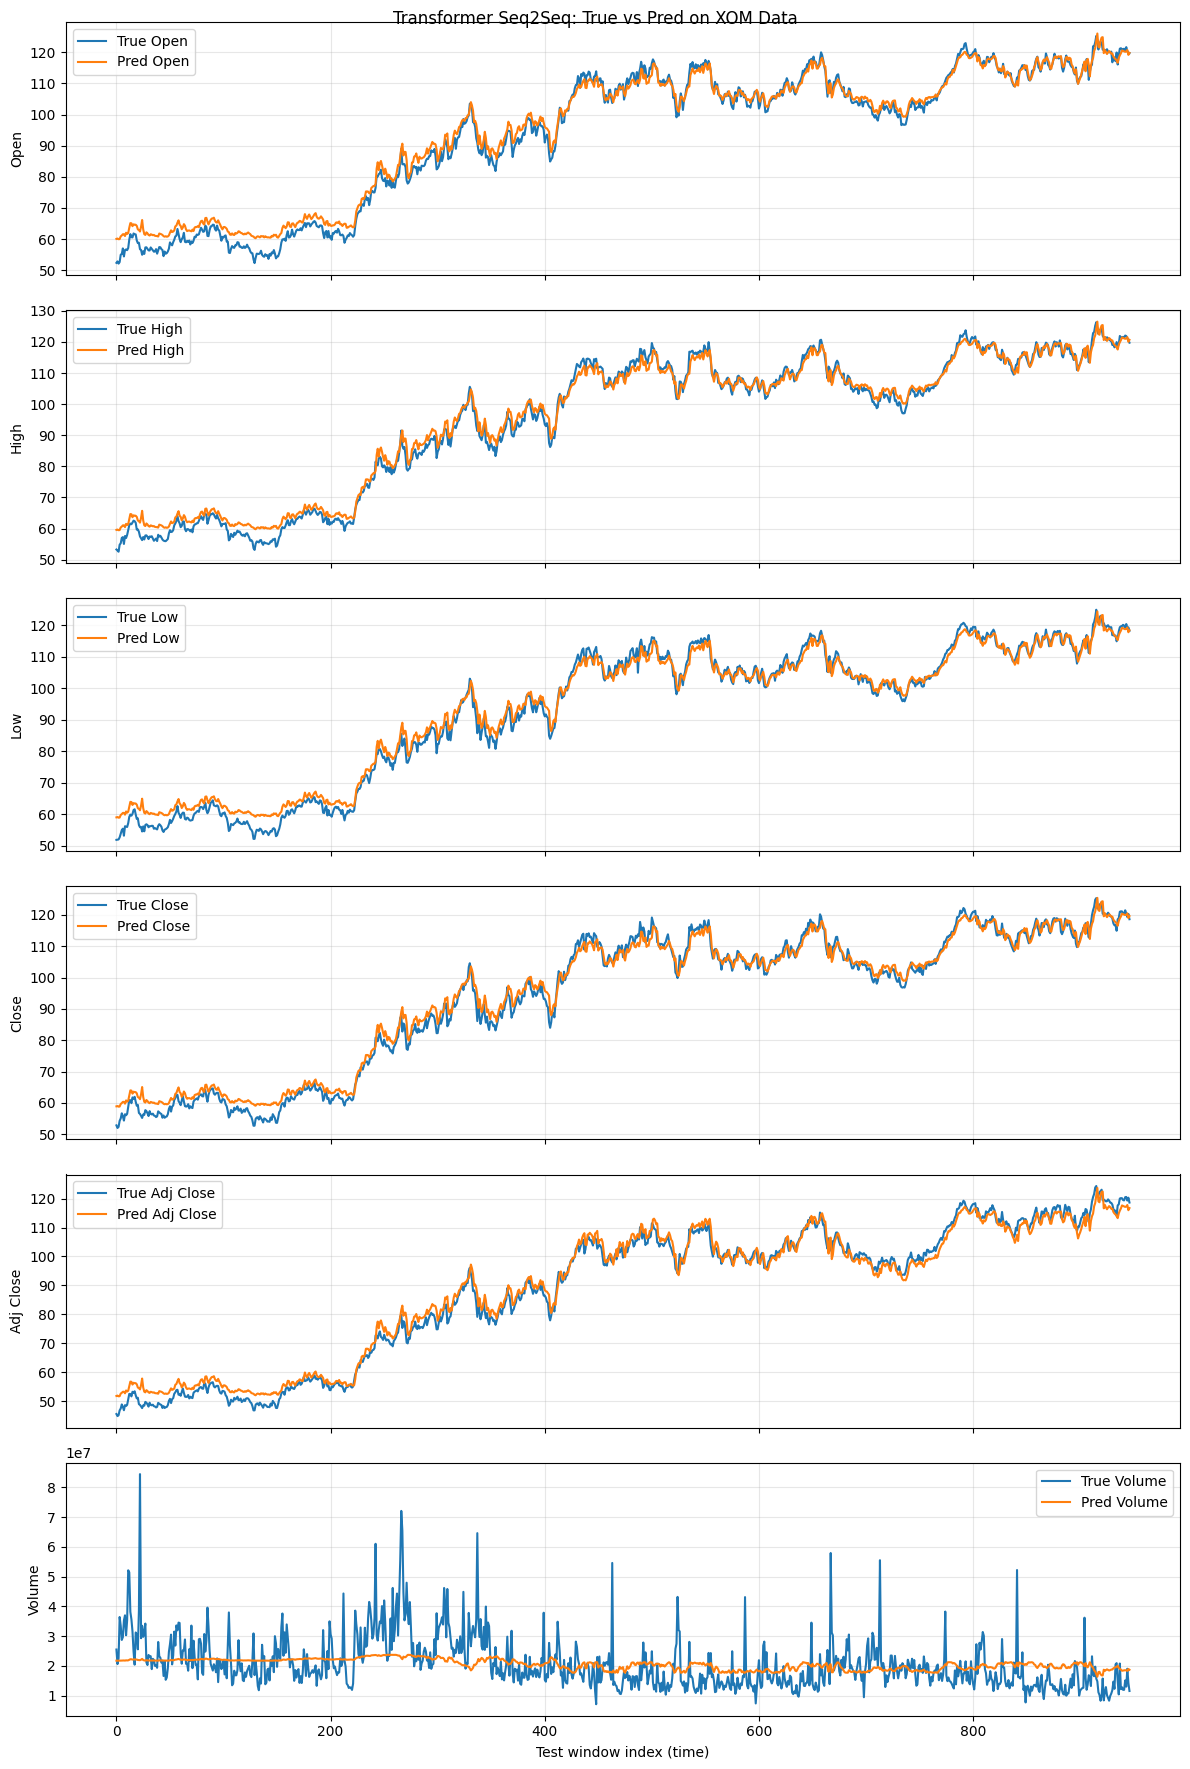

In [38]:

n_features = true_trans_orig.shape[1]
x = np.arange(true_trans_orig.shape[0])
fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features), sharex=True)
if n_features == 1:
    axes = [axes]

for i, ax in enumerate(axes):
    ax.plot(x, true_trans_orig[:, i], label=f"True {FEATURE_COLS[i]}")
    ax.plot(x, preds_trans_orig[:, i], label=f"Pred {FEATURE_COLS[i]}")
    ax.set_ylabel(FEATURE_COLS[i])
    ax.grid(True, alpha=0.3)
    ax.legend(loc="best")
axes[-1].set_xlabel("Test window index (time)")
plt.suptitle("Transformer Seq2Seq: True vs Pred on XOM Data")
fig.tight_layout()
plt.show()
